### Overview

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [2]:
## Importing all the required libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.layers import MaxPool2D, concatenate
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomContrast, RandomFlip, RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop, RandomZoom
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers, losses, metrics

%matplotlib inline

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
## Printing the current working directory
os.getcwd()

'D:\\MS_Upgrad\\5_Deep_Learning\\Assignment_Melanoma_Detection\\Melanoma Detection Assignment'

### Importing the cancer data

In [4]:
### Seting the path for training and test data

train_data = "D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Train"
test_data = "D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Test"

In [5]:
# Defining the path object for train and test images

data_dir_train = pathlib.Path(train_data)
data_dir_test = pathlib.Path(test_data)

In [6]:
data_dir_train

WindowsPath('D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Train')

In [7]:
## Training and Test dataset size

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of images in trainig data set: ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number if images in test data set: ", image_count_test)

Number of images in trainig data set:  2239
Number if images in test data set:  118


### Loading the data from directories using Keras data generator function

#### Create a dataset

Defining parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180
input_shape = (img_height, img_width, 3)

Use 80% of the images for training, and 20% for validation.

In [9]:
## Creataing Train data generator

train_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                           batch_size=batch_size,
                                                           image_size=(img_height, img_width),
                                                           seed=123,
                                                           validation_split=0.2,
                                                           subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Creating Test data generator

val_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                           batch_size=batch_size,
                                                           image_size=(img_height, img_width),
                                                           seed=123,
                                                           validation_split=0.2,
                                                           subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
## Listing cancer classes

class_names = train_ds.class_names
num_class = len(class_names)
print(f"There are {num_class} classes in the data set, they are;\n\n",class_names)

There are 9 classes in the data set, they are;

 ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualizing one instance of all the nine classes present in the dataset

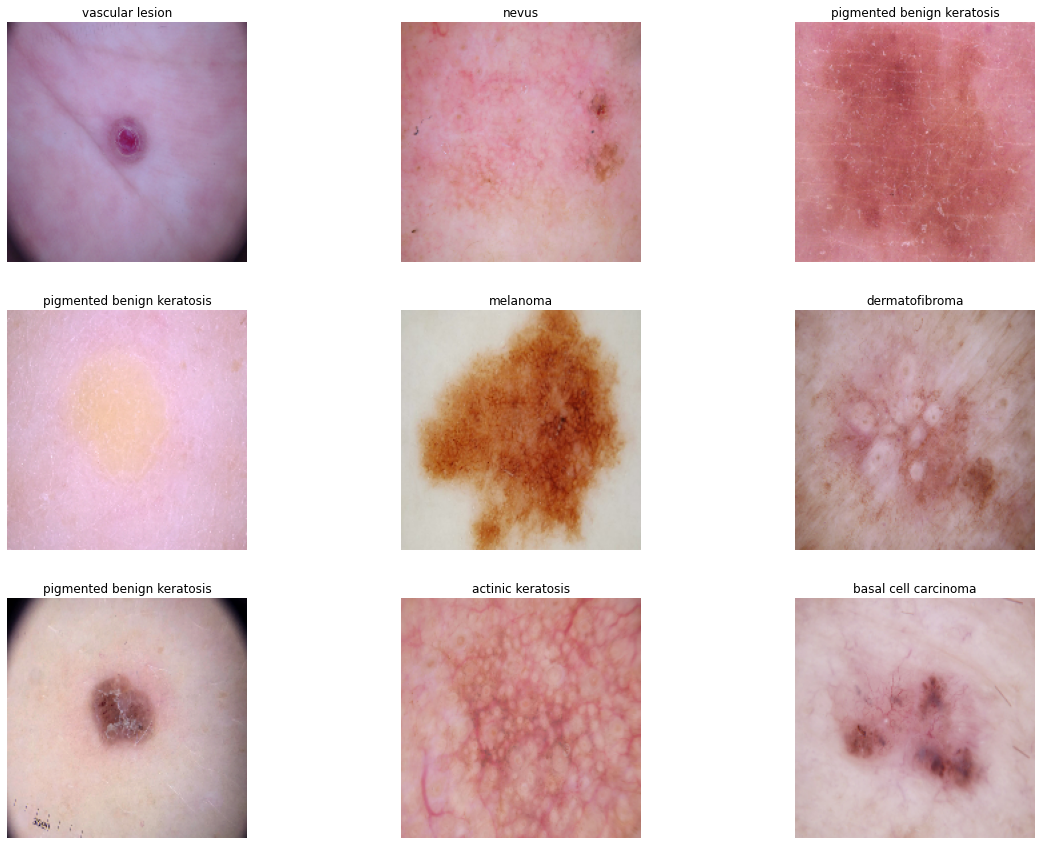

In [13]:
# Visualizing one random instance of nine classes

plt.figure(figsize=(20, 15))
for images, labels in train_ds.take(1):
    for i in range(num_class):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [ ]:
# ## Visualizing one random instance of nine classes

# fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
# count = 0
# for row in ax:
#     for col in row:
#         path = os.path.join(train_data, class_names[count])
#         rand = np.random.randint(len(os.listdir(path)))
#         file = os.listdir(path)[rand]
#         img = plt.imread(os.path.join(path, file))
#         col.grid(False)
#         col.axis('off')
#         col.set_title(class_names[count])
#         count+=1
        

# plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Experiment 1 :: Base model

#### Model defination

- A shallow CNN netwrok is created with 4 CNN layers and 2 Fully Connected Layers
- Each CNN layer is followed by a Maxpooling layer to downsize the dimenstion
- Rescaling of input is done to get the values between 0 and 1
- `Relu` activation is used in CNN layers
- `Softmax` function is used at the last FC layer 

In [15]:
### BASE CNN Model constuction

model = Sequential()
model.add(Rescaling(1./255, input_shape = input_shape))
model.add(Conv2D(16, 3, padding='same',  activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32, 3, padding='same',  activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64, 3, padding='same',  activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128, 3, padding='same',  activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_class, activation='softmax'))

# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

#### Compile the model
- Adam optimizer is used
- Sparse Categorical CrossEntropy is used as loss function since we are dealing with multi-class labels and formated as one hot encoding (,9)
- Accuracy is used as the performance metrics

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

#### Train the model
- Model is trained with a batch size of 32 for 20 epochs

In [17]:
%%time
epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                   )

Epoch 1/20
56/56 [==============================] - 8s 36ms/step - loss: 1.9091 - accuracy: 0.3225 - val_loss: 1.8471 - val_accuracy: 0.3065
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.5884 - accuracy: 0.4319 - val_loss: 1.5589 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4293 - accuracy: 0.4894 - val_loss: 1.3849 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3682 - accuracy: 0.5117 - val_loss: 1.5018 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2910 - accuracy: 0.5458 - val_loss: 1.3529 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3156 - accuracy: 0.5335 - val_loss: 1.5180 - val_accuracy: 0.52353083 - accu
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2373 - accuracy: 0.5698 - val_loss: 1.3527 - val_accuracy: 0.5481
Ep

#### Visualizing training results

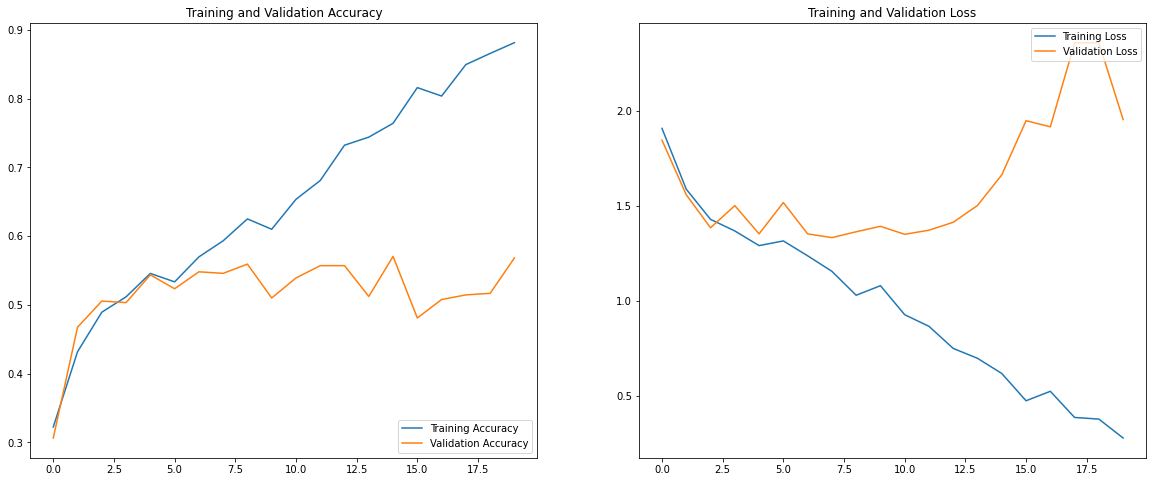

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
print("Train Accuracy after 20 epochs: %.2f" %(max(acc)*100))
print("Validation Accuracy:  %.2f"%(max(val_acc)*100))

Train Accuracy after 20 epochs: 88.11
Validation Accuracy:  57.05


#### Findings

- From the accuracy graph we see that model **`Overfits`** to some degree, as the training accuracy is about 88% and validation accuracy is about 57%. Also exibits high variance. 
- After 5 epochs the validation loss has increased also the validation accuracy has flattened.
- This could be because some of the classes are under represented (less samples), and model is learning noice in the data. 

#### Model Treatment

- Since the model is overfitting, we can use data augmentation strategy to generate more data to improve the model performance
- As the image is not constrained by the sape of the infected area following data augmentation strategy can used. 
    - Flips (Vertical and Horizontal)
    - Rotation (Various degree
    - Zooming
    - Contrast variation
    - Translation
- will apply random transformations 
- Since model is has some overfitting we will try model with only augmented data but without Dropout Layer

In [31]:
## Data Augmentation

data_aug = Sequential([
    RandomContrast(0.05),
    RandomFlip('horizontal_and_vertical'),
    RandomRotation((-0.1, 0.1)), 
    RandomZoom(0.1)])

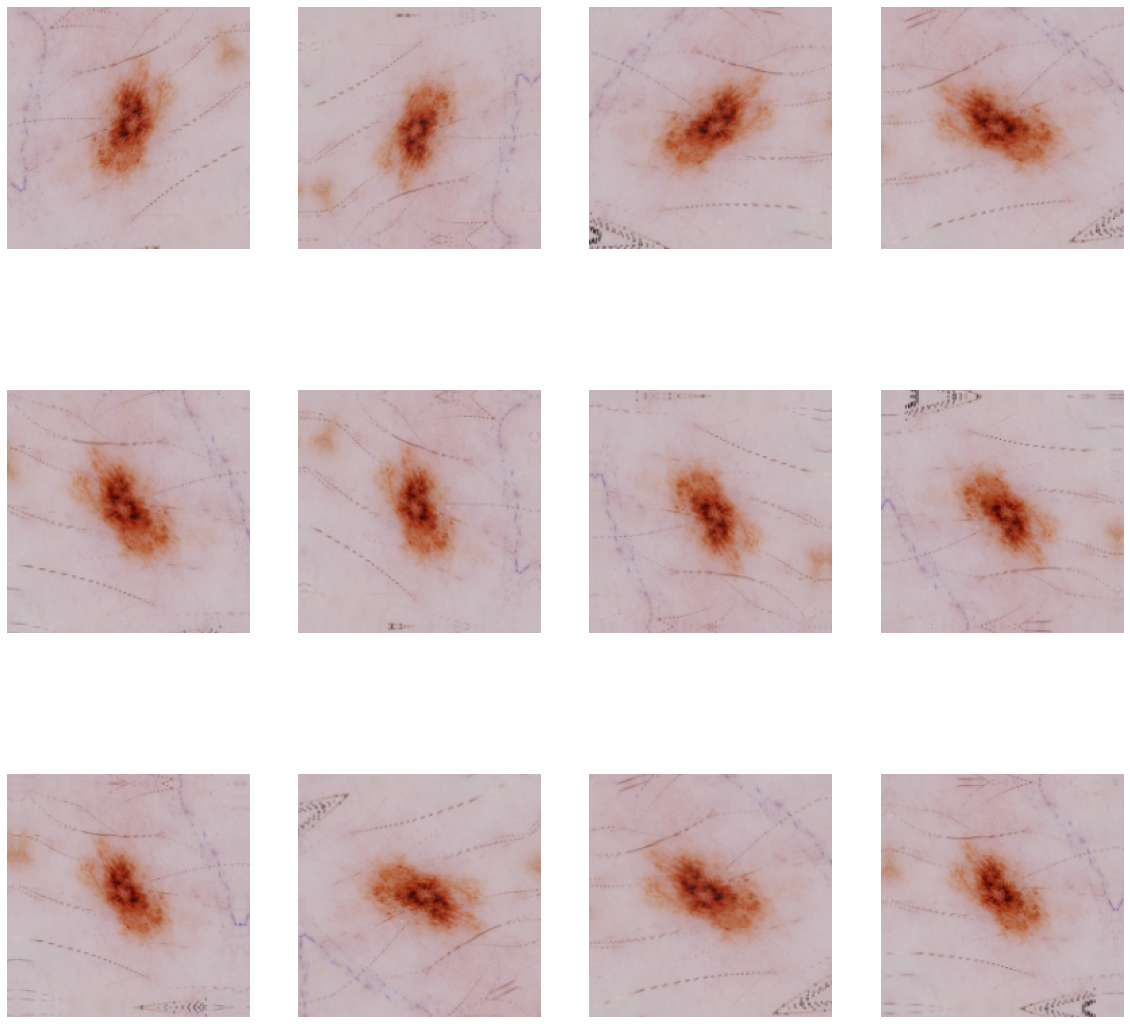

In [33]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(20, 20))
for imgs, _ in train_ds.take(1):
    for i in range(12):
        aug_img = data_aug(imgs)
        ax = plt.subplot(3,4, i+1)
        plt.imshow(aug_img[0].numpy().astype('uint8'))
        plt.axis('off')


### Experiment 2 :: Model Training with data agumentation
- Following data augmentation techniques are used;
    - Random Contrast
    - Random Flip
    - Random Rotation
    - Random Zoom

#### Model Defination

In [34]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
    Rescaling(1./255, input_shape=input_shape),
    data_aug,
    Conv2D(16, 3, padding='same',  activation='relu'),
    MaxPool2D(2,2),
    Conv2D(32, 3, padding='same',  activation='relu'),
    MaxPool2D(2,2),
    Conv2D(64, 3, padding='same',  activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128, 3, padding='same',  activation='relu'),
    MaxPool2D(2,2),
#     Dropout(0.2),
    Flatten(),
    Dense(1000, activation='relu'),
    Dense(num_class, activation='softmax')])

# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 64)       

#### Compiling the model

In [35]:
## Compiling the model
model.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

#### Training the model

In [36]:
%%time
## Training the model for 20 epochs
epochs = 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                   )

Epoch 1/20
56/56 [==============================] - 3s 29ms/step - loss: 1.8748 - accuracy: 0.2991 - val_loss: 1.9626 - val_accuracy: 0.3423
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6447 - accuracy: 0.4096 - val_loss: 1.6388 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 1s 25ms/step - loss: 1.4660 - accuracy: 0.4838 - val_loss: 1.5752 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4483 - accuracy: 0.4900 - val_loss: 1.4040 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3632 - accuracy: 0.5123 - val_loss: 1.4297 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3029 - accuracy: 0.5335 - val_loss: 1.4098 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2857 - accuracy: 0.5357 - val_loss: 1.4151 - val_accuracy: 0.5213
Epoch 8/20
56

#### Visualizing the results

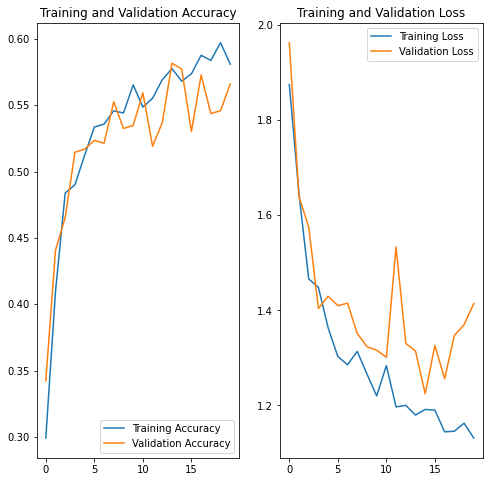

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
print("Train Accuracy after 20 epochs: %.2f" %(max(acc)*100))
print("Validation Accuracy:  %.2f"%(max(val_acc)*100))

Train Accuracy after 20 epochs: 59.71
Validation Accuracy:  58.17


#### Findings

- The data augmentation has helped model to reduced the training accuracy and narrowed difference the training and validation accuracies, that means though the training accuracy is low, model would be able to gneralize better
- The validation accuracy has slightly improved from 57% to 58%
- We can also see the validation loss closely follows the traing loss and difference is narrowed 

### Class Distribution in Training data set

In [39]:
## Finding class distribution

cls_count = {}
for cls in class_names:
    path = pathlib.Path(os.path.join(train_data, cls))
    count = len(list(path.glob('*.jpg')))
    cls_count[cls]=count
cls_count

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

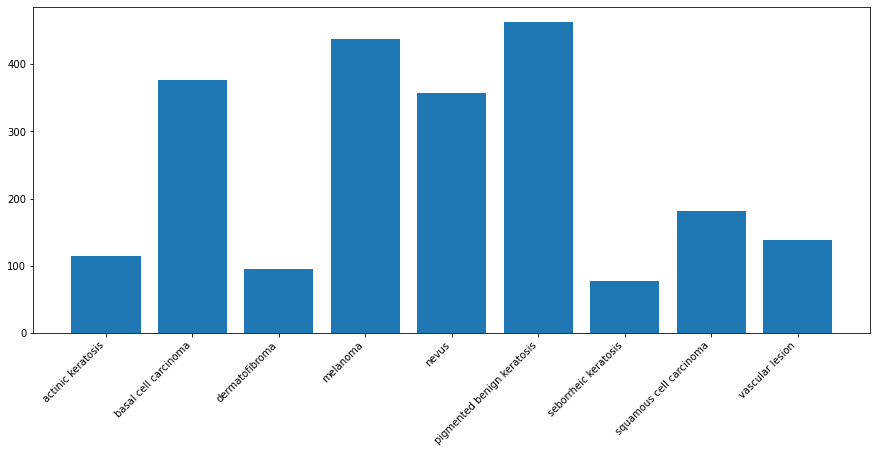

In [40]:
## Ploting the class distribution

plt.figure(figsize=(15, 6))
plt.bar(list(cls_count.keys()), list(cls_count.values()))
plt.xticks(rotation = 45, ha = 'right');

#### Findings


- The data set is imbalanced
- Classes ***'basal cell carcinoma', 'melanoma', 'nevus', and 'pigmented benign keratosis'***, have higher number of represntations
- Classes ***'actinic keratosis', 'dermatofibroma','seborrheic keratosis', 'squamous cell carcinoma'  'vascular lesion'*** have lower numbers of samples
- Class `'pigmented benign keratosis'` has highest samples = 462
- Class `'seborrheic keratosis'` has lowest samples= 77


#### Rectify the class imbalance

- Smaller number of samples results in model learning noise from the data, unable to extract the useful features from the data
- It is important to have good amount of data for the model to learn the useful features and improve the prediction power of the model 
- It is also improtant to have class balance for better infering the performance of the model
- `Augmentor` (https://augmentor.readthedocs.io/en/master/) is used to generate mode data for all the classes with some data transformation techniques (Rotation)
- This brings down the class imbalance issue

In [ ]:
#!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
## Augmenting the data

path_to_training_dataset=train_data
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +'/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E6F9971670>: 100%|█| 500/500 [00:02<00:00, 182.93 Samples


Initialised with 376 image(s) found.
Output directory set to D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E6F99ABD60>: 100%|█| 500/500 [00:02<00:


Initialised with 95 image(s) found.
Output directory set to D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E6F9944BE0>: 100%|█| 500/500 [00:02<00:


Initialised with 438 image(s) found.
Output directory set to D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1E6F9964160>: 100%|█| 500/500 [00:13<00:00, 38.18 Sample


Initialised with 357 image(s) found.
Output directory set to D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x1E6F999F160>: 100%|█| 500/500 [00:12<00:00, 40.94 Samples/


Initialised with 462 image(s) found.
Output directory set to D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E6F48480D0>: 100%|█| 500/500 [00:03<00:


Initialised with 77 image(s) found.
Output directory set to D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1E6F4835B20>: 100%|█| 500/500 [00:06<00:00, 76.56 Samples


Initialised with 181 image(s) found.
Output directory set to D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E6F99966A0>: 100%|█| 500/500 [00:03<00:


Initialised with 139 image(s) found.
Output directory set to D:/MS_Upgrad/5_Deep_Learning/Assignment_Melanoma_Detection/data/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E6F48295B0>: 100%|█| 500/500 [00:02<00:00, 179.33 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [42]:
## Counting the data size after augmentation

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Data distribution after treating for class imbalance

In [43]:
## path of individual images from original data

path_list_old = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list_old)

2239

In [44]:
## classnames for individual images from original data

lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(lesion_list_old)

2239

In [45]:
## creating data frame of image path and classname

dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))

In [46]:
df1 = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])
df1.head()

,Path,Label
0,D:\MS_Upgrad\5_Deep_Learning\Assignment_Melano...,actinic keratosis
1,D:\MS_Upgrad\5_Deep_Learning\Assignment_Melano...,actinic keratosis
2,D:\MS_Upgrad\5_Deep_Learning\Assignment_Melano...,actinic keratosis
3,D:\MS_Upgrad\5_Deep_Learning\Assignment_Melano...,actinic keratosis
4,D:\MS_Upgrad\5_Deep_Learning\Assignment_Melano...,actinic keratosis


In [47]:
## path of individual images from augmented data

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)

4500

In [48]:
## classnames for individual images from augmented data

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [49]:
## creating data frame of image path and classname

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [50]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df1.append(df2)

C:\Users\dhana\AppData\Local\Temp\ipykernel_2252\1533296750.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = df1.append(df2)


In [51]:
## Class wise count of data after agumentation (including original data)

new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [52]:
len(new_df)

6739

### Experiment 3 :: After increasing the training samples using Augmentor 

In [53]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating training dataset

In [54]:
data_dir_train=train_data

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating validation dataset

In [55]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model Defination

In [63]:
## your code goes here

model = Sequential([
    Rescaling(1./255, input_shape=input_shape),
    Conv2D(16, 3, padding='same',  activation='relu'),
    MaxPool2D(2,2),
    Conv2D(32, 3, padding='same',  activation='relu'),
    MaxPool2D(2,2),
    Conv2D(64, 3, padding='same',  activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128, 3, padding='same',  activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.2),
    Flatten(),
    Dense(1000, activation='relu'),
    Dense(num_class, activation='softmax')])

# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 22, 22, 64)       

#### Model compilation

In [64]:
## Compiling the model
model.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

#### Model Training

In [65]:
%%time
## Training the model for 30 epochs
epochs = 30
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                   )

Epoch 1/30
169/169 [==============================] - 11s 62ms/step - loss: 1.9162 - accuracy: 0.2702 - val_loss: 1.5512 - val_accuracy: 0.4024
Epoch 2/30
169/169 [==============================] - 10s 59ms/step - loss: 1.4905 - accuracy: 0.4314 - val_loss: 1.5189 - val_accuracy: 0.4024
Epoch 3/30
169/169 [==============================] - 10s 59ms/step - loss: 1.3441 - accuracy: 0.4891 - val_loss: 1.3116 - val_accuracy: 0.5085
Epoch 4/30
169/169 [==============================] - 11s 61ms/step - loss: 1.1864 - accuracy: 0.5519 - val_loss: 1.1139 - val_accuracy: 0.5976
Epoch 5/30
169/169 [==============================] - 10s 59ms/step - loss: 1.0110 - accuracy: 0.6209 - val_loss: 1.0444 - val_accuracy: 0.6310
Epoch 6/30
169/169 [==============================] - 10s 59ms/step - loss: 0.8869 - accuracy: 0.6725 - val_loss: 0.8741 - val_accuracy: 0.6956
Epoch 7/30
169/169 [==============================] - 10s 58ms/step - loss: 0.7072 - accuracy: 0.7398 - val_loss: 0.7888 - val_accuracy:

#### **Todo:**  Visualize the model results

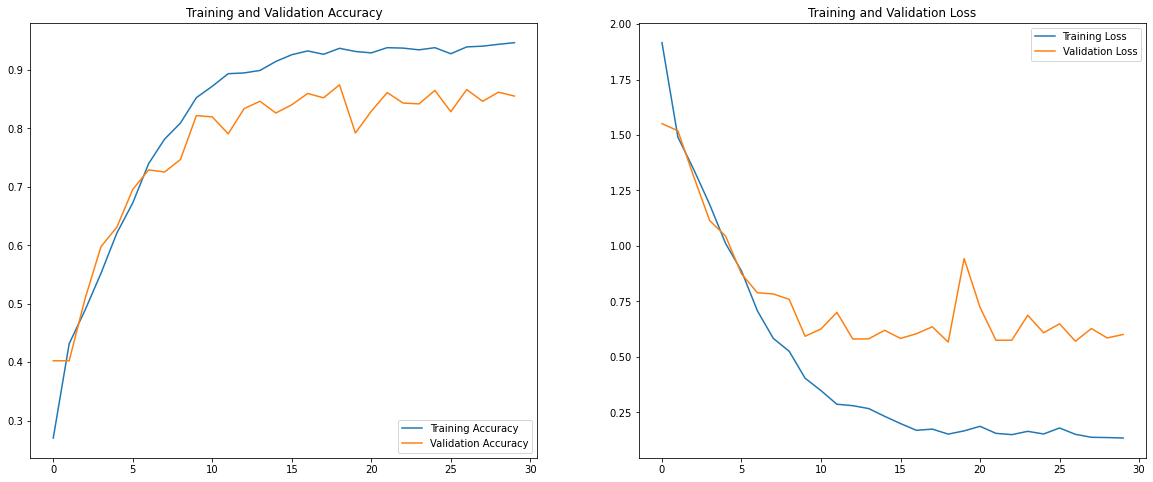

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [67]:
print("Train Accuracy after 20 epochs: %.2f" %(max(acc)*100))
print("Validation Accuracy:  %.2f"%(max(val_acc)*100))

Train Accuracy after 20 epochs: 94.66
Validation Accuracy:  87.45


#### Findings

- Use of agumented data to incease the number of samples for each class has resulted in improved model performance
- Both Training and Validation Accuracy has increased - Training accuracy = 94.6% and Validation accuracy = 87.5%
- The difference in the training and validation accuracy also has reduced, resulting in lower variance model, model has more generalizability